In [1]:
from matplotlib import pyplot as plt
from graph_cnn.graph import create_final_graph
import networkx as nx
from graph_cnn.model import create_model 
import tensorflow as tf
from graph_cnn.graph import mutate
from graph_cnn.individual import Individual

2024-01-29 18:25:41.405867: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-29 18:25:41.409753: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 18:25:41.475518: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 18:25:41.475578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 18:25:41.477406: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

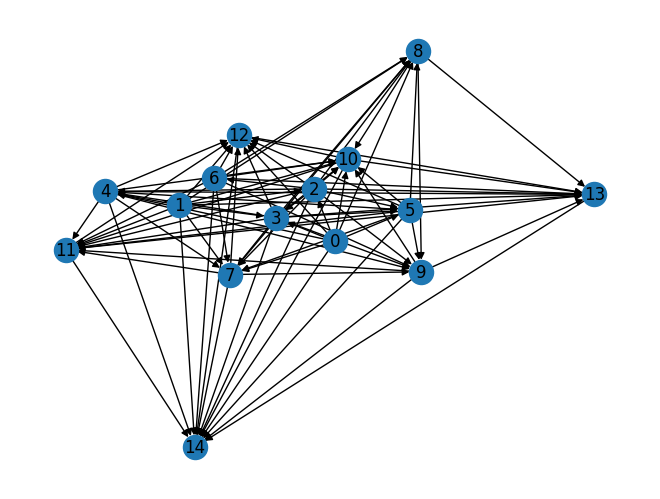

In [2]:
g1 = create_final_graph(15,0.8)
nx.draw(g1, with_labels=True)
plt.draw()

OutEdgeDataView([(0, 2, {'_igraph_index': 0}), (0, 3, {'_igraph_index': 2}), (0, 4, {'_igraph_index': 5}), (0, 5, {'_igraph_index': 9}), (0, 7, {'_igraph_index': 14}), (0, 8, {'_igraph_index': 21}), (0, 10, {'_igraph_index': 35}), (0, 12, {'_igraph_index': 53}), (0, 14, {'_igraph_index': 73}), (1, 2, {'_igraph_index': 1}), (1, 3, {'_igraph_index': 3}), (1, 4, {'_igraph_index': 6}), (1, 7, {'_igraph_index': 15}), (1, 8, {'_igraph_index': 22}), (1, 10, {'_igraph_index': 36}), (1, 11, {'_igraph_index': 44}), (1, 12, {'_igraph_index': 54}), (1, 13, {'_igraph_index': 63}), (1, 14, {'_igraph_index': 74}), (2, 3, {'_igraph_index': 4}), (2, 4, {'_igraph_index': 7}), (2, 5, {'_igraph_index': 10}), (2, 6, {'_igraph_index': 13}), (2, 7, {'_igraph_index': 16}), (2, 8, {'_igraph_index': 23}), (2, 9, {'_igraph_index': 28}), (2, 10, {'_igraph_index': 37}), (2, 11, {'_igraph_index': 45}), (2, 12, {'_igraph_index': 55}), (2, 13, {'_igraph_index': 64}), (2, 14, {'_igraph_index': 75}), (3, 4, {'_igraph_i

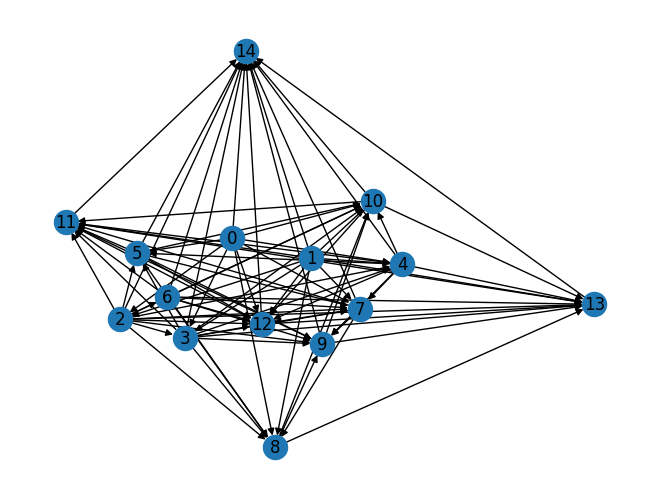

In [3]:
nx.draw(g1, with_labels=True)
plt.draw()
g1.edges(data=True)

In [4]:
g1.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14))

In [5]:
'''import numpy as np
import random
import tensorflow_datasets as tfds

#import minst dataset and split to test trin
mnist_dataset, mnist_info = tfds.load(name='crema_d', with_info=True, as_supervised=True)

def scale(waveform, label):
    waveform = tf.cast(waveform,tf.float64)
    spectrogram = tf.signal.stft(
    waveform, frame_length=255, frame_step=28)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    spectrogram = tf.image.resize(spectrogram,(28,28))
    label = tf.one_hot(label, 6)
    return spectrogram, label

train_data = mnist_dataset['train'].map(scale)
test_data = mnist_dataset['test'].map(scale)
train_image , train_label = next(iter(train_data.batch(1)))

train_ds = train_data.shuffle(10).cache().prefetch(10).batch(64)
test_ds = test_data.cache().prefetch(10).batch(64)

print(train_image.shape)
print(train_label.shape)'''

"import numpy as np\nimport random\nimport tensorflow_datasets as tfds\n\n#import minst dataset and split to test trin\nmnist_dataset, mnist_info = tfds.load(name='crema_d', with_info=True, as_supervised=True)\n\ndef scale(waveform, label):\n    waveform = tf.cast(waveform,tf.float64)\n    spectrogram = tf.signal.stft(\n    waveform, frame_length=255, frame_step=28)\n    spectrogram = tf.abs(spectrogram)\n    spectrogram = spectrogram[..., tf.newaxis]\n    spectrogram = tf.image.resize(spectrogram,(28,28))\n    label = tf.one_hot(label, 6)\n    return spectrogram, label\n\ntrain_data = mnist_dataset['train'].map(scale)\ntest_data = mnist_dataset['test'].map(scale)\ntrain_image , train_label = next(iter(train_data.batch(1)))\n\ntrain_ds = train_data.shuffle(10).cache().prefetch(10).batch(64)\ntest_ds = test_data.cache().prefetch(10).batch(64)\n\nprint(train_image.shape)\nprint(train_label.shape)"

In [6]:
import numpy as np
import random
import tensorflow_datasets as tfds

mnist_dataset , mnist_info = tfds.load(name='cifar10', with_info=True, as_supervised=True,split=['train', 'test[:50%]'],shuffle_files=True)
train_data = mnist_dataset[0]
test_data = mnist_dataset[1]
def scale(image, label):
    image = tf.cast(image,tf.float64)
    image = image/255
    label = tf.one_hot(label, 10)
    return image, label
train_data = train_data.map(scale)
test_data = test_data.map(scale)
train_ds = train_data.cache().batch(64).prefetch(10)
test_ds = test_data.cache().batch(64).prefetch(10)
train_image , train_label = next(iter(train_data.batch(1)))
print(train_image.shape)
print(train_label)

/home/balasai/graph-cnn/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(1, 32, 32, 3)
tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]], shape=(1, 10), dtype=float32)


2024-01-29 18:25:46.528565: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:
'''!pip install -q opendatasets

import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/puneet6060/intel-image-classification')
'''

"!pip install -q opendatasets\n\nimport opendatasets as od\nimport pandas as pd\n\nod.download('https://www.kaggle.com/datasets/puneet6060/intel-image-classification')\n"

In [8]:
'''import tensorflow as tf
import os
import glob
import numpy as np
import random

import tensorflow as tf
import os
import glob
import numpy as np

class CustomImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size=32, image_size=(128, 128), shuffle=True):
        self.directory = directory
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.filepaths = self._get_filepaths()
        self.indexes = np.arange(len(self.filepaths))
        self.class_mapping = self._create_class_mapping()
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _get_filepaths(self):
        pattern = os.path.join(self.directory, '*/*.jpg')  # Assuming PNG format, modify as needed
        filepaths = glob.glob(pattern)
        random.shuffle(filepaths)
        return filepaths

    def _create_class_mapping(self):
        classes = sorted(set(os.listdir(self.directory)))
        print(len(classes))
        class_mapping = {cls: idx for idx, cls in enumerate(classes)}
        return class_mapping

    def _load_and_preprocess_image(self, filepath):
        image = tf.keras.preprocessing.image.load_img(filepath, target_size=self.image_size, color_mode='grayscale')
        image = tf.keras.preprocessing.image.img_to_array(image)
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
        )
        image = image.reshape((1,) + image.shape)
        augmented_image = datagen.flow(image).next()[0]
        image = augmented_image / 255.0  # Normalize to [0, 1]
        return image

    def __len__(self):
        return int(np.ceil(len(self.filepaths) / self.batch_size))

    def _downsample(self, batch_images, batch_labels):
        unique_labels, label_counts = np.unique(batch_labels.argmax(axis=1), return_counts=True)
        min_label_count = np.min(label_counts)

        downsampled_images = []
        downsampled_labels = []

        for label in unique_labels:
            label_indices = np.where(batch_labels.argmax(axis=1) == label)[0]
            selected_indices = np.random.choice(label_indices, size=min_label_count, replace=False)

            downsampled_images.extend(batch_images[selected_indices])
            downsampled_labels.extend(batch_labels[selected_indices])

        downsampled_images = np.array(downsampled_images)
        downsampled_labels = np.array(downsampled_labels)

        # Shuffle the downsampled data
        shuffle_indices = np.arange(len(downsampled_labels))
        np.random.shuffle(shuffle_indices)

        return downsampled_images[shuffle_indices], downsampled_labels[shuffle_indices]

    def __getitem__(self, index):
        batch_filepaths = self.filepaths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for filepath in batch_filepaths:
            image = self._load_and_preprocess_image(filepath)
            label_str = os.path.basename(os.path.dirname(filepath))
            label = self.class_mapping[label_str]
            label = tf.keras.utils.to_categorical(label,6)

            batch_images.append(image)
            batch_labels.append(label)

        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)
        
        batch_images, batch_labels = self._downsample(batch_images, batch_labels)

        return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Example usage:
train_generator = CustomImageDataGenerator(directory='intel-image-classification/seg_train/seg_train', batch_size=512)
test_generator = CustomImageDataGenerator(directory='intel-image-classification/seg_test/seg_test', batch_size=512)

# Rest of the code remains the same...


train_ds = tf.data.Dataset.from_generator(
    generator=lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None,128,128,1), dtype=tf.float32),
        tf.TensorSpec(shape=(None,6), dtype=tf.float32),
    )
).cache()

test_ds = tf.data.Dataset.from_generator(
    generator=lambda: test_generator,
    output_signature=(
        tf.TensorSpec(shape=(None,128,128,1), dtype=tf.float32),
        tf.TensorSpec(shape=(None,6), dtype=tf.float32),
    )
).cache()

for epoch in range(5):
    for batch_x, batch_y in test_ds:
        print(batch_x.shape)
        print(batch_y.shape)
        print(batch_y)
        break'''

"import tensorflow as tf\nimport os\nimport glob\nimport numpy as np\nimport random\n\nimport tensorflow as tf\nimport os\nimport glob\nimport numpy as np\n\nclass CustomImageDataGenerator(tf.keras.utils.Sequence):\n    def __init__(self, directory, batch_size=32, image_size=(128, 128), shuffle=True):\n        self.directory = directory\n        self.batch_size = batch_size\n        self.image_size = image_size\n        self.shuffle = shuffle\n        self.filepaths = self._get_filepaths()\n        self.indexes = np.arange(len(self.filepaths))\n        self.class_mapping = self._create_class_mapping()\n        if self.shuffle:\n            np.random.shuffle(self.indexes)\n\n    def _get_filepaths(self):\n        pattern = os.path.join(self.directory, '*/*.jpg')  # Assuming PNG format, modify as needed\n        filepaths = glob.glob(pattern)\n        random.shuffle(filepaths)\n        return filepaths\n\n    def _create_class_mapping(self):\n        classes = sorted(set(os.listdir(self.

In [9]:
model = create_model(g1,(32,32,3),10)

(None, 3, 3, 286)
(None, 1, 1, 286)


ValueError: Exception encountered when calling layer "aux_layer" (type AuxLayer).

in user code:

    File "/home/balasai/graph-cnn/graph_cnn/model/model.py", line 35, in call  *
        inputs = layer(inputs)
    File "/home/balasai/graph-cnn/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'max_pooling2d' (type MaxPooling2D).
    
    Negative dimension size caused by subtracting 2 from 1 for '{{node aux_layer/max_pooling2d/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](aux_layer/activation/Relu)' with input shapes: [?,1,1,32].
    
    Call arguments received by layer 'max_pooling2d' (type MaxPooling2D):
      • inputs=tf.Tensor(shape=(None, 1, 1, 32), dtype=float32)


Call arguments received by layer "aux_layer" (type AuxLayer):
  • inputs=tf.Tensor(shape=(None, 3, 3, 286), dtype=float32)

In [ ]:

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),
                                                                                                               #tf.keras.metrics.AUC(from_logits=True),
                                                                                                               #tf.keras.metrics.Precision(),
                                                                                                               #tf.keras.metrics.Recall()
                                                                                                               ])

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
'''g1 = create_random_graph(5,0.5)
g1 = assign_states(g1,(1,3,1))
fig , ax = plt.subplots(2,1)
g3 = mutate_dag(g1)
nx.draw(g1, with_labels=True, ax=ax[0])
nx.draw(g3, with_labels=True, ax=ax[1])
plt.draw()'''


In [ ]:
'''g4 = crossover(g1,g3)
fig , ax = plt.subplots(2,1)
nx.draw(g1, with_labels=True, ax=ax[0])
nx.draw(g4, with_labels=True, ax=ax[1])
plt.draw()'''

In [ ]:
in1 = Individual((32,32,3),(10),15,0.8)
tf.keras.utils.plot_model(in1.model, to_file='model.png', show_shapes=True)
model = in1.model
#visualkeras.layered_view(model, to_file='output.png').show() # view model structure in jupyter (suggested)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output

class ClassificationMatrixCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        y_pred =  np.array(self.model.predict(test_ds))
        print(y_pred.shape)
        if len(y_pred.shape) == 3:
            y_pred = y_pred[0]
        predicted_labels = np.argmax(y_pred, axis=1)
        true_labels = np.concatenate([y for x, y in test_ds], axis=0)
        print(true_labels.shape,predicted_labels.shape)
        true_labels = np.argmax(true_labels,axis=-1)
        cm = confusion_matrix(true_labels, predicted_labels)
        print(cm)

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
class_names = ['0','1','2','3','4','5','6','7','8','9']
callback = [ClassificationMatrixCallback(),
            #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10),]
metrics = [tf.keras.metrics.AUC(from_logits=True),tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='prc', curve='PR')]
model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[
                                                                                            tf.keras.metrics.Accuracy(),
                                                                                            tf.keras.metrics.AUC(from_logits=True),
                                                                                            tf.keras.metrics.CategoricalAccuracy(),
                                                                                            #tf.keras.metrics.Precision(),
                                                                                            #tf.keras.metrics.Recall(),
                                                                                            tf.keras.metrics.AUC(name='prc', curve='PR'),
                                                                                            ]
                                                                                            )
model.summary()
class_names = ['0','1','2','3','4','5','6','7','8','9']

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.fit(train_ds,validation_data=test_ds, epochs=30,
          #steps_per_epoch=50,
           callbacks=[callback],)

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
from graph_cnn.generation.generate import Generation
ga = Generation(input_size=(128,128,1),output_size=(102),nodes=13
,edges=0.8,population=17,limit=18,train_ds=train_ds,test_ds=test_ds,optimizer=optimizer,loss=loss,metrics=metrics,callbacks=callback)
ga.run(10,0.8,0.8)